In [1]:

import numpy as np
from nilearn import datasets
from nilearn.input_data import NiftiLabelsMasker
from nilearn.image import index_img
import nibabel as nib
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import KFold
# from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture

brain_data = datasets.fetch_oasis_vbm(n_subjects=100)
yeo = datasets.fetch_atlas_schaefer_2018(n_rois=100) # this needs to be modified for some tasks
print('%i regions found in this atlas' % (len(np.unique(nib.load(yeo.maps).get_data().ravel())) 
- 1))
masker = NiftiLabelsMasker(labels_img=yeo.maps, standardize=True, 
memory='nilearn_cache')
input_variables = masker.fit_transform(brain_data.gray_matter_maps)
output_variable = np.array(brain_data.ext_vars.mf == b'F', dtype=np.int) # gives 1 for females and 0 for males

train_input = input_variables[:90]
train_output = output_variable[:90]
test_input = input_variables[90:]
test_output = output_variable[90:]

     |████████████████████████████████| 10.0 MB 21.5 MB/s 


/usr/local/lib/python3.7/dist-packages/nilearn/datasets/__init__.py:96: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  "Numpy arrays.", FutureWarning)



Dataset created in /root/nilearn_data/oasis1



Downloaded 896778240 of 905208634 bytes (99.1%,    0.2s remaining) ...done. (19 seconds, 0 min)
Extracting data from /root/nilearn_data/oasis1/adcb228c7b26ed4f4fba93bd32bf8d97/archive_dartel.tgz..... done.
/usr/local/lib/python3.7/dist-packages/numpy/lib/npyio.py:2349: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  output = genfromtxt(fname, **kwargs)
 ...done. (0 seconds, 0 min)



Dataset created in /root/nilearn_data/schaefer_2018



 ...done. (0 seconds, 0 min)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


100 regions found in this atlas


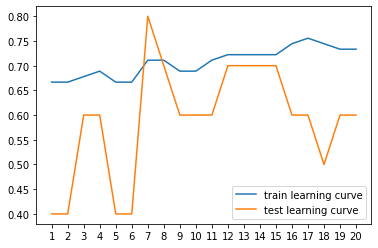

In [5]:

x_list = [] ### n_rois
train_y_list = [] ### accuracy
test_y_list = []

for i in range(1,21):
  ### GMM ####
  GMM = GaussianMixture(n_components=i, random_state=42).fit(train_input) ### feature engineering on train_split
  gmm_train_input = GMM.predict_proba(train_input)
  gmm_test_input = GMM.predict_proba(test_input)

  LogReg = LogisticRegression()

  model = make_pipeline(PolynomialFeatures(2),LogReg)
  model.fit(gmm_train_input, train_output)
  
  log_predict_train = model.predict(gmm_train_input)
  log_predict_output = model.predict(gmm_test_input)
  test_accuracy = np.sum(log_predict_output == test_output)/len(test_output)
  train_accuracy = np.sum(log_predict_train == train_output)/len(train_output)

  x_list.append(i) 
  train_y_list.append(train_accuracy) 
  test_y_list.append(test_accuracy)

plt.xticks(x_list)
plt.plot(x_list,train_y_list,label='train learning curve')
plt.plot(x_list,test_y_list,label='test learning curve')
  
plt.legend()
plt.show()